# Hand movement classification using EMG signals

In [8]:
import os

# Establishing the current work directory (cwd)
thisdir = "C:\\Users\\ENVY\\Desktop\\MachineLearningProject\\emg-signal-classification\\EMG_data_for_gestures-master\\EMG_data_for_gestures-master"
Files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(thisdir):
    for file in f:
        if ".txt" in file:
            Files.append(os.path.join(r, file))
filenames = Files

print(Files)
print(len(Files))

['C:\\Users\\ENVY\\Desktop\\MachineLearningProject\\emg-signal-classification\\EMG_data_for_gestures-master\\EMG_data_for_gestures-master\\01\\1_raw_data_13-12_22.03.16.txt', 'C:\\Users\\ENVY\\Desktop\\MachineLearningProject\\emg-signal-classification\\EMG_data_for_gestures-master\\EMG_data_for_gestures-master\\01\\2_raw_data_13-13_22.03.16.txt', 'C:\\Users\\ENVY\\Desktop\\MachineLearningProject\\emg-signal-classification\\EMG_data_for_gestures-master\\EMG_data_for_gestures-master\\02\\1_raw_data_14-19_22.03.16.txt', 'C:\\Users\\ENVY\\Desktop\\MachineLearningProject\\emg-signal-classification\\EMG_data_for_gestures-master\\EMG_data_for_gestures-master\\02\\2_raw_data_14-21_22.03.16.txt', 'C:\\Users\\ENVY\\Desktop\\MachineLearningProject\\emg-signal-classification\\EMG_data_for_gestures-master\\EMG_data_for_gestures-master\\03\\1_raw_data_09-32_11.04.16.txt', 'C:\\Users\\ENVY\\Desktop\\MachineLearningProject\\emg-signal-classification\\EMG_data_for_gestures-master\\EMG_data_for_gestures

## Libraries


In [9]:
import seaborn as sn; sn.set() 
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from mpl_toolkits.axes_grid1 import make_axes_locatable
from pandas import set_option

import scipy.signal as signal
from pywt import dwt,Wavelet

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
import matplotlib.pyplot as plt
from pandas import set_option
import pandas as pd
import numpy as np 
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn 
import keras

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline


##  Creating different DataFrames for train, validation and test (raw data)

In [13]:
import os
import pandas as pd
import numpy as np
from scipy import signal
from sklearn.preprocessing import StandardScaler
from collections import Counter

# === CONFIGURATION ===
WINDOW_SIZE = 100
STEP_SIZE_G7 = 6                # 94% overlap for gesture 7
STEP_SIZE_OTHERS = 100           # No overlap for gestures 0–6
FS = 1000
UNDERSAMPLE_RATIO = 0.12          # Reduce class 0 size

# === FEATURE EXTRACTION ===
def extract_features(window):
    rms = np.sqrt(np.mean(window**2, axis=0))
    zcr = np.sum(np.diff(np.sign(window), axis=0) != 0, axis=0)
    wl = np.sum(np.abs(np.diff(window, axis=0)), axis=0)
    return np.concatenate([rms, zcr, wl])

# === PROCESS ONE FILE ===
def process_emg_file_selective_overlap(file_path):
    df = pd.read_csv(file_path, sep="\t")

    if "time" in df.columns:
        df = df.drop(columns=["time"])

    # Undersample class 0
    zeros = df[df['class'] == 0]
    nonzeros = df[df['class'] != 0]
    if not zeros.empty:
        zeros = zeros.sample(frac=UNDERSAMPLE_RATIO, random_state=42)
    df = pd.concat([zeros, nonzeros]).sort_index().reset_index(drop=True)

    # Bandpass filter (20–40 Hz)
    wp = 40 / (FS / 2)
    ws = 20 / (FS / 2)
    b, a = signal.iirdesign(wp, ws, gpass=1, gstop=60, ftype='butter')
    for ch in df.columns[:-1]:
        df[ch] = signal.filtfilt(b, a, df[ch])

    # Normalize
    scaler = StandardScaler()
    df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1])

    X, y = [], []

    # Process gesture 7 with 50% overlap
    df_g7 = df[df['class'] == 7]
    for start in range(0, len(df_g7) - WINDOW_SIZE + 1, STEP_SIZE_G7):
        window = df_g7.iloc[start:start + WINDOW_SIZE, :-1].values
        labels = df_g7.iloc[start:start + WINDOW_SIZE]['class'].values
        if len(set(labels)) == 1:
            X.append(extract_features(window))
            y.append(labels[0])

    # Process other gestures (0–6) with NO overlap
    df_rest = df[df['class'].isin([0, 1, 2, 3, 4, 5, 6])]
    for start in range(0, len(df_rest) - WINDOW_SIZE + 1, STEP_SIZE_OTHERS):
        window = df_rest.iloc[start:start + WINDOW_SIZE, :-1].values
        labels = df_rest.iloc[start:start + WINDOW_SIZE]['class'].values
        if len(set(labels)) == 1 :  # Exclude pure class 0
            X.append(extract_features(window))
            y.append(labels[0])

    return X, y

# === SUMMARY PRINTER ===
def print_gesture_summary(label_list):
    counter = Counter(label_list)
    print("\n🧮 Overall Sample Count per Gesture:")
    for gesture in sorted(counter):
        print(f"Gesture {int(gesture)}: {counter[gesture]} samples")

# === PROCESS ALL SUBJECTS ===
def process_all_subjects(base_path, output_dir="subjects_csv"):
    os.makedirs(output_dir, exist_ok=True)

    global_label_list = []

    for subject_folder in sorted(os.listdir(base_path)):
        subject_path = os.path.join(base_path, subject_folder)
        if not os.path.isdir(subject_path):
            continue

        all_X, all_y = [], []

        for file in os.listdir(subject_path):
            if file.endswith(".txt"):
                file_path = os.path.join(subject_path, file)
                X, y = process_emg_file_selective_overlap(file_path)
                all_X.extend(X)
                all_y.extend(y)

        global_label_list.extend(all_y)

        if all_X:
            feature_cols = [f'RMS_{i+1}' for i in range(8)] + \
                           [f'ZCR_{i+1}' for i in range(8)] + \
                           [f'WL_{i+1}' for i in range(8)]

            df = pd.DataFrame(all_X, columns=feature_cols)
            df['label'] = all_y
            output_file = os.path.join(output_dir, f"subject_{subject_folder}.csv")
            df.to_csv(output_file, index=False)
            print(f"✅ Saved: {output_file} ({len(df)} samples)")
        else:
            print(f"⚠️ No data found for subject {subject_folder}")

    # Print summary
    print_gesture_summary(global_label_list)

# === RUN ===
process_all_subjects(thisdir)


✅ Saved: subjects_csv\subject_01.csv (472 samples)
✅ Saved: subjects_csv\subject_02.csv (483 samples)
✅ Saved: subjects_csv\subject_03.csv (413 samples)
✅ Saved: subjects_csv\subject_04.csv (454 samples)
✅ Saved: subjects_csv\subject_05.csv (424 samples)
✅ Saved: subjects_csv\subject_06.csv (409 samples)
✅ Saved: subjects_csv\subject_07.csv (551 samples)
✅ Saved: subjects_csv\subject_08.csv (424 samples)
✅ Saved: subjects_csv\subject_09.csv (435 samples)
✅ Saved: subjects_csv\subject_10.csv (462 samples)
✅ Saved: subjects_csv\subject_11.csv (1648 samples)
✅ Saved: subjects_csv\subject_12.csv (488 samples)
✅ Saved: subjects_csv\subject_13.csv (688 samples)
✅ Saved: subjects_csv\subject_14.csv (416 samples)
✅ Saved: subjects_csv\subject_15.csv (429 samples)
✅ Saved: subjects_csv\subject_16.csv (450 samples)
✅ Saved: subjects_csv\subject_17.csv (468 samples)
✅ Saved: subjects_csv\subject_18.csv (491 samples)
✅ Saved: subjects_csv\subject_19.csv (462 samples)
✅ Saved: subjects_csv\subject_

## Function to print metrics of a model.

In [3]:

def metrics(Y_validation, predictions):
    print('Accuracy:', accuracy_score(Y_validation, predictions))
    print('F1 score:', f1_score(Y_validation, predictions, average='weighted'))
    print('Recall:', recall_score(Y_validation, predictions, average='weighted'))
    print('Precision:', precision_score(Y_validation, predictions, average='weighted'))
    print('\nClassification Report:\n', classification_report(Y_validation, predictions))
    print('\nConfusion Matrix:\n', confusion_matrix(Y_validation, predictions))

    # Plotting confusion matrix
    labels = sorted(list(set(Y_validation) | set(predictions)))
    snn_cm = confusion_matrix(Y_validation, predictions, labels=labels)
    snn_df_cm = pd.DataFrame(snn_cm, index=labels, columns=labels)

    plt.figure(figsize=(12, 8))
    sn.set(font_scale=1.2)
    sn.heatmap(snn_df_cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 14})
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## Tuning KNN model, n_neighbors parameter

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# === CONFIGURATION ===
DATA_DIR = "./subjects_csv"  # Make sure this path is correct
K = 6
OUTPUT_FILE = "knn-results.csv"

# === Load all subject files ===
subject_files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith(".csv")])

results = []
print("this model is just created as the starting point for our model, it is not used for any predictions, just made it \nto further understand the data, the cababilities of the model and how to adjust the parameters for the model due to its simplicity. ")
print("🔁 Starting Leave-One-Subject-Out Cross-Validation...")

for i, test_file in enumerate(subject_files):
    test_path = os.path.join(DATA_DIR, test_file)

    # Load test subject
    test_df = pd.read_csv(test_path)

    # Load training subjects (all except current)
    train_files = subject_files[:i] + subject_files[i+1:]
    train_df = pd.concat([pd.read_csv(os.path.join(DATA_DIR, f)) for f in train_files], ignore_index=True)

    # Split features and labels
    X_train = train_df.drop(columns=['label'])
    y_train = train_df['label']
    X_test = test_df.drop(columns=['label'])
    y_test = test_df['label']

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and evaluate KNN
    knn = KNeighborsClassifier(n_neighbors=K)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    results.append({
        'Subject': test_file,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

    print(f"[{i+1:02d}/36] Subject {test_file} - Accuracy: {acc:.4f}")

# === Convert results to DataFrame and save ===
results_df = pd.DataFrame(results)
results_df.to_csv(OUTPUT_FILE, index=False)

# === Summary Output ===
print("\n📊 Leave-One-Subject-Out Summary:")
print(results_df[['Subject', 'Accuracy']])
print(f"\n✅ Average Accuracy Across All Subjects (k={K}): {results_df['Accuracy'].mean():.4f}")
print(f"📁 Results saved to {OUTPUT_FILE}")

this model is just created as the starting point for our model, it is not used for any predictions, just made it 
to further understand the data, the cababilities of the model and how to adjust the parameters for the model due to its simplicity. 
🔁 Starting Leave-One-Subject-Out Cross-Validation...
[01/36] Subject subject_01.csv - Accuracy: 0.7100
[02/36] Subject subject_02.csv - Accuracy: 0.7513
[03/36] Subject subject_03.csv - Accuracy: 0.8184
[04/36] Subject subject_04.csv - Accuracy: 0.8154
[05/36] Subject subject_05.csv - Accuracy: 0.8989
[06/36] Subject subject_06.csv - Accuracy: 0.7424
[07/36] Subject subject_07.csv - Accuracy: 0.4646
[08/36] Subject subject_08.csv - Accuracy: 0.8507
[09/36] Subject subject_09.csv - Accuracy: 0.9222
[10/36] Subject subject_10.csv - Accuracy: 0.8338
[11/36] Subject subject_11.csv - Accuracy: 0.2425
[12/36] Subject subject_12.csv - Accuracy: 0.7476
[13/36] Subject subject_13.csv - Accuracy: 0.8515
[14/36] Subject subject_14.csv - Accuracy: 0.7275


## Gaussian Naive Bayes model

In [32]:
import os
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# === CONFIGURATION ===
DATA_DIR = "./subjects_csv"
OUTPUT_FILE = "gnb-results.csv"

# === Load subject files ===
subject_files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith(".csv")])

results = []

print("🔁 Starting Leave-One-Subject-Out Evaluation with Gaussian Naive Bayes...")

for i, test_file in enumerate(subject_files):
    test_path = os.path.join(DATA_DIR, test_file)
    test_df = pd.read_csv(test_path)

    # Load training data (all other subjects)
    train_files = subject_files[:i] + subject_files[i+1:]
    train_df = pd.concat([pd.read_csv(os.path.join(DATA_DIR, f)) for f in train_files], ignore_index=True)

    # Split features and labels
    X_train = train_df.drop(columns=['label'])
    y_train = train_df['label']
    X_test = test_df.drop(columns=['label'])
    y_test = test_df['label']

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Gaussian Naive Bayes
    gnb = GaussianNB()
    gnb.fit(X_train_scaled, y_train)
    y_pred = gnb.predict(X_test_scaled)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    results.append({
        'Subject': test_file,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })

# === Convert results to DataFrame and save ===
results_df = pd.DataFrame(results)
results_df.to_csv(OUTPUT_FILE, index=False)

# === Summary Output ===
print("\n📊 Leave-One-Subject-Out Summary:")
print(results_df[['Subject', 'Accuracy']])
print(f"\n✅ Average Accuracy Across All Subjects (GNB): {results_df['Accuracy'].mean():.4f}")
print(f"📁 Results saved to {OUTPUT_FILE}")

# === Identify Best Iteration ===
best_row = results_df.loc[results_df['F1 Score'].idxmax()]
print(f"\n🏅 Best Performance:")
print(f"Subject: {best_row['Subject']}")
print(f"Accuracy: {best_row['Accuracy']:.4f}")
print(f"Precision: {best_row['Precision']:.4f}")
print(f"Recall: {best_row['Recall']:.4f}")
print(f"F1 Score: {best_row['F1 Score']:.4f}")


🔁 Starting Leave-One-Subject-Out Evaluation with Gaussian Naive Bayes...

📊 Leave-One-Subject-Out Summary:
           Subject  Accuracy
0   subject_01.csv  0.692500
1   subject_02.csv  0.723350
2   subject_03.csv  0.854749
3   subject_04.csv  0.779487
4   subject_05.csv  0.879781
5   subject_06.csv  0.789474
6   subject_07.csv  0.352083
7   subject_08.csv  0.802817
8   subject_09.csv  0.945245
9   subject_10.csv  0.797954
10  subject_11.csv  0.239897
11  subject_12.csv  0.810680
12  subject_13.csv  0.745875
13  subject_14.csv  0.722071
14  subject_15.csv  0.816976
15  subject_16.csv  0.853234
16  subject_17.csv  0.725849
17  subject_18.csv  0.820823
18  subject_19.csv  0.743210
19  subject_20.csv  0.889435
20  subject_21.csv  0.741758
21  subject_22.csv  0.505495
22  subject_23.csv  0.876190
23  subject_24.csv  0.793689
24  subject_25.csv  0.785908
25  subject_26.csv  0.684636
26  subject_27.csv  0.842893
27  subject_28.csv  0.761290
28  subject_29.csv  0.662437
29  subject_30.csv  0.1

## Tuning Random forest model, n_estimators parameter

In [15]:
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from joblib import Parallel, delayed
import numpy as np

# === CONFIGURATION ===
DATA_DIR = "./subjects_csv"
N_ESTIMATORS_LIST = [50, 100, 150, 200]  # Fewer tree counts for speed
N_JOBS = -1                    # Use all CPU cores
RESULTS_DIR = "./rf_fast_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# === Load and cache all subject data ===
subject_files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith(".csv")])
subjects = [(f, pd.read_csv(os.path.join(DATA_DIR, f))) for f in subject_files]

# === Evaluation function ===
def evaluate_subject_rf(n_estimators, test_index):
    test_file, test_df = subjects[test_index]
    train_df = pd.concat([df for i, (_, df) in enumerate(subjects) if i != test_index], ignore_index=True)

    # Split
    X_train = train_df.drop(columns=['label'])
    y_train = train_df['label']
    X_test = test_df.drop(columns=['label'])
    y_test = test_df['label']

    # Scale
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train and predict
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    return {
        'Subject': test_file,
        'n_estimators': n_estimators,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }

# === Main loop for tree counts ===
for n_estimators in N_ESTIMATORS_LIST:
    print(f"⚡ Running LOSO for Random Forest ({n_estimators} trees)...")
    results = Parallel(n_jobs=N_JOBS)(
        delayed(evaluate_subject_rf)(n_estimators, i) for i in range(len(subjects))
    )

    # Save results
    df = pd.DataFrame(results)
    df.to_csv(f"{RESULTS_DIR}/rf_{n_estimators}_trees.csv", index=False)
    print(f"📁 Results saved to: rf_{n_estimators}_trees.csv\n")

# ✅ Done
print("✅ Fast evaluation complete.")


⚡ Running LOSO for Random Forest (50 trees)...
📁 Results saved to: rf_50_trees.csv

⚡ Running LOSO for Random Forest (100 trees)...
📁 Results saved to: rf_100_trees.csv

⚡ Running LOSO for Random Forest (150 trees)...
📁 Results saved to: rf_150_trees.csv

⚡ Running LOSO for Random Forest (200 trees)...
📁 Results saved to: rf_200_trees.csv

✅ Fast evaluation complete.


## Plotting n_estimators vs accuracy

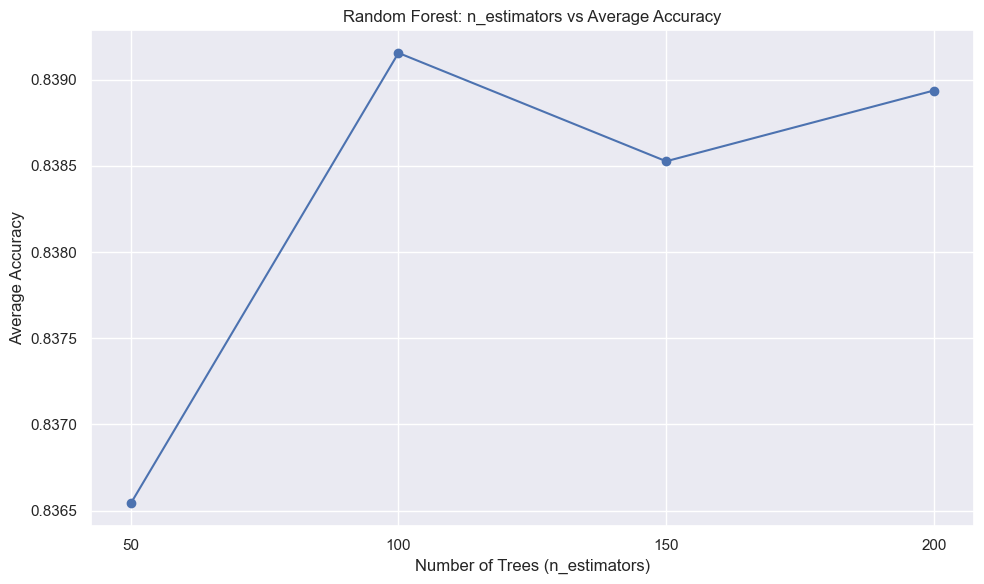

In [16]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# === CONFIGURATION ===
RESULTS_DIR = "./rf_fast_results"
files = [f for f in os.listdir(RESULTS_DIR) if f.endswith(".csv")]

# === Extract (n_estimators, avg_accuracy) pairs ===
data = []
for file in files:
    df = pd.read_csv(os.path.join(RESULTS_DIR, file))
    n_estimators = int(df['n_estimators'].iloc[0])
    avg_accuracy = df['Accuracy'].mean()
    data.append((n_estimators, avg_accuracy))

# === Sort by n_estimators numerically ===
data.sort(key=lambda x: x[0])  # Sort by number of trees

# === Split into separate lists for plotting ===
n_estimators_list, avg_accuracies = zip(*data)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, avg_accuracies, marker='o', linestyle='-')
plt.title('Random Forest: n_estimators vs Average Accuracy')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.xticks(n_estimators_list)
plt.tight_layout()
plt.savefig("rf_n_estimators_vs_accuracy.png", dpi=300)
plt.show()


## Creating a random forest model with 100 estimators and saving it

In [14]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from joblib import dump

# === CONFIGURATION ===
DATA_DIR = "./subjects_csv"
MODEL_SAVE_PATH = "./saved_rf_model.joblib"
os.makedirs(os.path.dirname(MODEL_SAVE_PATH), exist_ok=True)

# === Load and combine all data ===
subject_files = sorted([f for f in os.listdir(DATA_DIR) if f.endswith(".csv")])
all_data = pd.concat([pd.read_csv(os.path.join(DATA_DIR, f)) for f in subject_files], ignore_index=True)

# === Split features and labels ===
X = all_data.drop(columns=['label'])
y = all_data['label']

# === Scale the features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train the Random Forest ===
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_scaled, y)

# === Save the trained model ===
dump((scaler, model), MODEL_SAVE_PATH)

print(f"✅ Model and scaler saved to: {MODEL_SAVE_PATH}")


✅ Model and scaler saved to: ./saved_rf_model.joblib


In [ ]:
RF = RandomForestClassifier(n_estimators=x[yValidationScaler.index(max(yValidationScaler))])
RF.fit(Features_train_valid, Labels_train_valid)
predictions = RF.predict(Features_test_scaler)
metrics(Labels_test,predictions)

## Decision Tree model

In [ ]:
DT = DecisionTreeClassifier()
DT.fit(Features_train_scaler, Labels_train)
predictions = DT.predict(Features_test_scaler)
metrics(Labels_test,predictions)

## Cross validation of all models 

In [ ]:
def fold_creation(filenames, index):
    filenames_fold=[]
    filenames_fold.append(filenames[index[0]])
    filenames_fold.append(filenames[index[0]+1])
    filenames_fold.append(filenames[index[1]])
    filenames_fold.append(filenames[index[1]+1])
    filenames_fold.append(filenames[index[2]])
    filenames_fold.append(filenames[index[2]+1])
    filenames_fold.append(filenames[index[3]])
    filenames_fold.append(filenames[index[3]+1])

    [df1,df2,df3,df4,df5,df6]=Data_separation(filenames_fold[0])
    Gesto1=df1
    Gesto2=df2
    Gesto3=df3
    Gesto4=df4
    Gesto5=df5
    Gesto6=df6

    for i in range(len(filenames_fold[1:])):
        [df1,df2,df3,df4,df5,df6]=Data_separation(filenames[i])
        Gesto1=Gesto1.append(df1)
        Gesto2=Gesto2.append(df2)
        Gesto3=Gesto3.append(df3)
        Gesto4=Gesto4.append(df4)
        Gesto5=Gesto5.append(df5)
        Gesto6=Gesto6.append(df6)

    fold=Gesto1
    fold=fold.append(Gesto2)
    fold=fold.append(Gesto3)
    fold=fold.append(Gesto4)
    fold=fold.append(Gesto5)
    fold=fold.append(Gesto6)
    return fold

In [ ]:
pacientes = []
for i in range(0, 72, 2):
    pacientes.append(i)
index=np.random.choice(pacientes, (9, 4), replace=False)

In [ ]:
fold0=fold_creation(filenames, index[0])
fold1=fold_creation(filenames, index[1])
fold2=fold_creation(filenames, index[2])
fold3=fold_creation(filenames, index[3])
fold4=fold_creation(filenames, index[4])
fold5=fold_creation(filenames, index[5])
fold6=fold_creation(filenames, index[6])
fold7=fold_creation(filenames, index[7])
fold8=fold_creation(filenames, index[8])

In [ ]:
Labels_0 = fold0['class']
Features_0 = fold0[fold0.columns[0:8]]

Labels_1 = fold1['class']
Features_1 = fold1[fold1.columns[0:8]]

Labels_2 = fold2['class']
Features_2 = fold2[fold2.columns[0:8]]

Labels_3 = fold3['class']
Features_3 = fold3[fold3.columns[0:8]]

Labels_4 = fold4['class']
Features_4 = fold4[fold4.columns[0:8]]

Labels_5 = fold5['class']
Features_5 = fold5[fold5.columns[0:8]]

Labels_6 = fold6['class']
Features_6 = fold6[fold6.columns[0:8]]

Labels_7 = fold7['class']
Features_7 = fold7[fold7.columns[0:8]]

Labels_8 = fold8['class']
Features_8 = fold8[fold8.columns[0:8]]

In [ ]:
Features_full = Features_0.append(Features_1)
Features_full = Features_full.append(Features_2)
Features_full = Features_full.append(Features_3)
Features_full = Features_full.append(Features_4)
Features_full = Features_full.append(Features_5)
Features_full = Features_full.append(Features_6)
Features_full = Features_full.append(Features_7)
Features_full = Features_full.append(Features_8)

scaler = preprocessing.StandardScaler().fit(Features_full)
Features_fold0 = scaler.transform(Features_0)
Features_fold1 = scaler.transform(Features_1)
Features_fold2 = scaler.transform(Features_2)
Features_fold3 = scaler.transform(Features_3)
Features_fold4 = scaler.transform(Features_4)
Features_fold5 = scaler.transform(Features_5)
Features_fold6 = scaler.transform(Features_6)
Features_fold7 = scaler.transform(Features_7)
Features_fold8 = scaler.transform(Features_8)

In [ ]:
folds = [Features_fold0, Features_fold1, Features_fold2, Features_fold3, Features_fold4, Features_fold5, Features_fold6, Features_fold7, Features_fold8]
labels = [Labels_0, Labels_1, Labels_2, Labels_3, Labels_4, Labels_5, Labels_6, Labels_7, Labels_8]

In [ ]:
def manual_cross_val(model, folds, labels):
    Results = []
    index_t = [[0, 1, 2, 3, 4, 5, 6, 7], [8, 0, 1, 2, 3, 4, 5, 6], [7, 8, 0, 1, 2, 3, 4, 5], [6, 7, 8, 0, 1, 2, 3, 4], [5, 6, 7, 8, 0, 1, 2, 3]
            , [4, 5, 6, 7, 8, 0, 1, 2], [3, 4, 5, 6, 7, 8, 0, 1], [2, 3, 4, 5, 6, 7, 8, 0], [1, 2, 3, 4, 5, 6, 7, 8]]
    index_v = [8, 7, 6, 5, 4, 3 , 2, 1, 0]
    for i in range(len(index_t)):
      Train = folds[index_t[i][0]]
      Trainlabels = labels[index_t[i][0]]
      for j in range(len(index_t[i][1:])):
          Train = np.append(Train, folds[index_t[i][j]], axis=0)
          Trainlabels = np.append(Trainlabels, labels[index_t[i][j]], axis=0)
      Valid = folds[index_v[i]]
      Validlabels = labels[index_v[i]]
      model.fit(Train, Trainlabels)
      pred = model.predict(Valid)
      Results.append(accuracy_score(Validlabels, pred))
    return [np.mean(Results), np.std(Results)]

KNN = KNeighborsClassifier(n_neighbors=1)
lr = LogisticRegression(C=0.3)
NB = GaussianNB()
MLP = MLPClassifier(solver='adam', alpha=.5, hidden_layer_sizes=800)
RF = RandomForestClassifier(n_estimators=71)
DT = DecisionTreeClassifier()

In [ ]:
R_KNN = manual_cross_val(KNN, folds, labels)
print('KNN: ', R_KNN[0], R_KNN[1])
R_lr = manual_cross_val(lr, folds, labels)
print('LR: ', R_lr[0], R_lr[1])
R_NB = manual_cross_val(NB, folds, labels)
print('NB: ', R_NB[0], R_NB[1])
R_MLP = manual_cross_val(MLP, folds, labels)
print('MLP: ', R_MLP[0], R_MLP[1])
R_RF = manual_cross_val(RF, folds, labels)
print('RF: ', R_RF[0], R_RF[1])
R_DT = manual_cross_val(DT, folds, labels)
print('DT: ', R_DT[0], R_DT[1])